In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

In [4]:
# Generate a plot of MAP from the results in results_csv
def map_plot(results_csv_file, config, experiment_names):
    folder_path = "./"
    num_turns = config['dialogue_sim']['num_turns']
    results_df = pd.read_csv(results_csv_file)

    # Set up colours
    # import pdb; pdb.set_trace()
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(results_df))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title('Comparison of Item Selection Methods on MovieLens Subset')
    
    for row_num in range(len(results_df)):
        row_maps = []
        upper_bounds = []
        lower_bounds = []
        for turn in range(num_turns):
            row_maps.append(results_df.loc[row_num, 'map@%d' % turn])
            upper_bounds.append(results_df.loc[row_num, 'map@%d_ub' % turn])
            lower_bounds.append(results_df.loc[row_num, 'map@%d_lb' % turn])

        plt.plot(np.linspace(1,num_turns,num_turns), row_maps, marker="o", linestyle="solid", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.plot(np.linspace(1,num_turns,num_turns), upper_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.plot(np.linspace(1,num_turns,num_turns), lower_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.fill_between(np.linspace(1,num_turns,num_turns), upper_bounds, lower_bounds, color=colors[row_num], alpha=.1)

    # Set axis labels
    plt.xticks(np.arange(1, num_turns+1, step=1))
    plt.ylabel('MAP')
    plt.xlabel('Turn #')

    # Create a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(results_df))]
    plt.legend(handles, [exp_name for exp_name in experiment_names], title='Experiments')

    plt.ylim(0,1)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    file_name = folder_path + "test_plot.png"
    fig.savefig(file_name)

    plt.show()

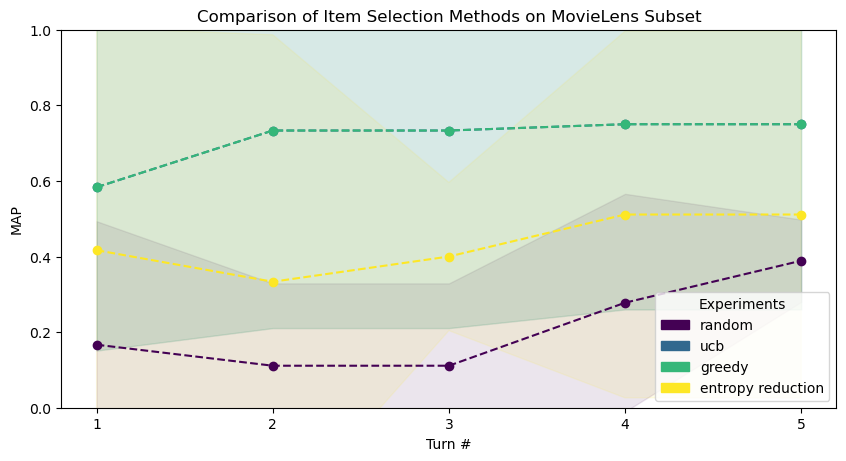

In [5]:
config = {'dialogue_sim': {'num_turns': 5}}
results_csv_file = "experiments/dt_methods/aggregated_results.csv"
experiment_names = ["random", "ucb", "greedy", "entropy reduction"]
map_plot(results_csv_file, config, experiment_names)